In [1]:
# importing dependencies
import pandas as pd # data frame
import numpy as np # matrix math
from scipy.io import wavfile # reading the wavfile
import os # interation with the OS
from sklearn.utils import shuffle # shuffling of data
from random import sample # random selection
from tqdm import tqdm # progress bar
import matplotlib.pyplot as plt # to view graphs

# audio processing
from scipy import signal # audio processing
from scipy.fftpack import dct
import librosa # library for audio processing


In [2]:
PATH = '../input/train/audio/'

In [3]:
def load_files(path):
	# write the complete file loading function here, this will return
	# a dataframe having files and labels
	# loading the files
	train_labels = os.listdir(PATH)
	train_labels.remove('_background_noise_')

	labels_to_keep = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence']

	train_file_labels = dict()
	for label in train_labels:
		files = os.listdir(PATH + '/' + label)
		for f in files:
			train_file_labels[label + '/' + f] = label

	train = pd.DataFrame.from_dict(train_file_labels, orient='index')
	train = train.reset_index(drop=False)
	train = train.rename(columns={'index': 'file', 0: 'folder'})
	train = train[['folder', 'file']]
	train = train.sort_values('file')
	train = train.reset_index(drop=True)

	def remove_label_from_file(label, fname):
		return path + label + '/' + fname[len(label)+1:]

	train['file'] = train.apply(lambda x: remove_label_from_file(*x), axis=1)
	train['label'] = train['folder'].apply(lambda x: x if x in labels_to_keep else 'unknown')

	labels_to_keep.append('unknown')

	return train, labels_to_keep

In [4]:
train, labels_to_keep = load_files(PATH)

# making word2id dictr
word2id = dict((c,i+1) for i,c in enumerate(sorted(labels_to_keep)))

print(word2id)

# get some files which will be labeled as unknown
unk_files = train.loc[train['label'] == 'unknown']['file'].values
# randomly selecting 3000 files
unk_files = sample(list(unk_files), 3000)

{'down': 1, 'go': 2, 'left': 3, 'no': 4, 'off': 5, 'on': 6, 'right': 7, 'silence': 8, 'stop': 9, 'unknown': 10, 'up': 11, 'yes': 12}


In [5]:
def log_specgram(audio, sample_rate, window_size=10, 
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    _, _, spec = signal.spectrogram(audio, fs=sample_rate,
                                    window='hann', nperseg=nperseg, noverlap=noverlap,
                                    detrend=False)
    return np.log(spec.T.astype(np.float32) + eps)

def audio_to_data(path):
    # we take a single path and convert it into data
    sample_rate, audio = wavfile.read(path)
    spectrogram = log_specgram(audio, sample_rate, 10, 0)
    return spectrogram.T

def paths_to_data(paths, word2id, unk = False):
    data = np.zeros(shape = (len(paths), 81, 100))
    labels = []
    indexes = []
    for i in tqdm(range(len(paths))):
        f = paths[i]
        audio = audio_to_data(paths[i])
        if audio.shape != (81,100):
            indexes.append(i)
        else:
            data[i] = audio
        # print('Number of instances with inconsistent shape:', len(indexes))
        # mode, if unk is set we are doing it for unknown files
        if unk == True:
            labels.append(word2id['unknown'])
        else:
            labels.append(word2id[f.split('/')[-2]])

    return data, labels, indexes

In [6]:
files = train.loc[train['label'] != 'unknown']['file'].values
print("[!]For labled data...")
data, l, i = paths_to_data(files[:1], word2id)

100%|██████████| 1/1 [00:00<00:00, 449.31it/s]

[!]For labled data...


Text(0.5,1,'Log Spectrogram')

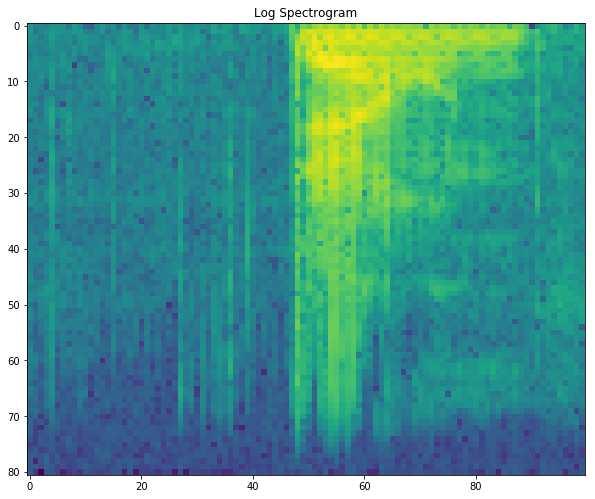

In [7]:
plt.figure(figsize = (10, 10))
plt.imshow(data[0])
plt.title('Log Spectrogram')

## MFCC and Filter Bank Sample

I learned it from Haytham Fayek's excellent blog post on the topic. You can read it at http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html.

In [8]:
def mfcc_features(path_file, frame_size, frame_stride):
    sample_rate, signal = wavfile.read(path_file)
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    # params
    '''frame_size = 0.025
    frame_stride = 0.01'''
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) +\
        np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # hamming window
    frames *= np.hamming(frame_length)

    NFFT = 512
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    
    num_ceps = 20
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
    
    cep_lifter = 22
    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift  #*
    
    return filter_banks, mfcc

def normalized_fb(fb):
    fb -= (np.mean(fb, axis=0) + 1e-8)
    return fb

def normalized_mfcc(mfcc):
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    return mfcc

In [9]:
path_file = files[123]
frame_size = 0.05
frame_stride = 0.03
fb, mfcc = mfcc_features(path_file, frame_size, frame_stride)
print(fb.shape)
print(mfcc.shape)

(32, 40)
(32, 20)


Text(0.5,1,'Filter Bank')

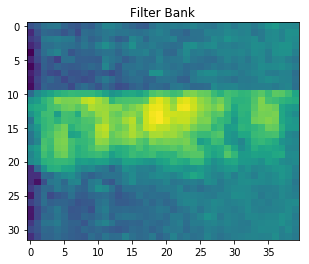

In [10]:
# plt.figure(figsize = fb.shape)
plt.imshow(fb)
plt.title('Filter Bank')

Text(0.5,1,'Normalized Filter Bank')

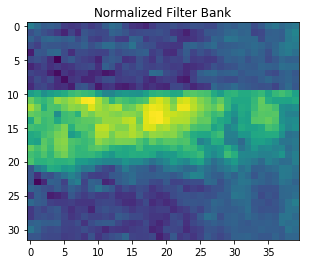

In [11]:
fb_n = normalized_fb(fb)
# plt.figure(figsize = (25, 10))
plt.imshow(fb_n)
plt.title('Normalized Filter Bank')

Text(0.5,1,'MFCC')

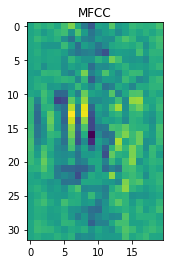

In [12]:
# plt.figure(figsize = mfcc.shape)
plt.imshow(mfcc)
plt.title('MFCC')

Text(0.5,1,'Normalized MFCC')

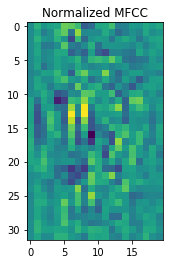

In [13]:
mfcc_n = normalized_mfcc(mfcc)
# plt.figure(figsize = (25, 10))
plt.imshow(mfcc_n)
plt.title('Normalized MFCC')

In [14]:
# sometimes we 

## Feature extraction using librosa

In [15]:
path_file = files[104]
audio, sr = librosa.load(path_file)

In [16]:
stft = np.abs(librosa.stft(audio))
# mfcc
mfcc_l = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T,axis=0)
# chroma
chroma_l = librosa.feature.chroma_stft(S=stft, sr=sr)
chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
# mel
mel_l = librosa.feature.melspectrogram(audio, sr=sr)
mel = np.mean(librosa.feature.melspectrogram(audio, sr=sr).T,axis=0)
# contrast
contrast_l = librosa.feature.spectral_contrast(S=stft, sr=sr)
contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T,axis=0)
# tonnetz
tonnetz_l = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr)
tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr).T,axis=0)

In [17]:
print(stft.shape)
print('mfcc')
print(mfcc_l.shape)
print(mfccs.shape)
print('chroma')
print(chroma_l.shape)
print(chroma.shape)
print('mel')
print(mel_l.shape)
print(mel.shape)
print('contrast')
print(contrast_l.shape)
print(contrast.shape)
print('tonnetz')
print(tonnetz_l.shape)
print(tonnetz.shape)

(1025, 44)
mfcc
(40, 44)
(40,)
chroma
(12, 44)
(12,)
mel
(128, 44)
(128,)
contrast
(7, 44)
(7,)
tonnetz
(6, 44)
(6,)


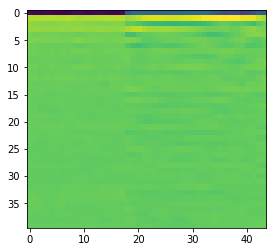

In [18]:
plt.imshow(mfcc_l)

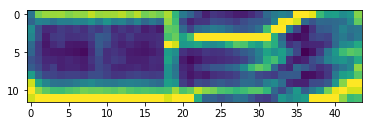

In [19]:
plt.imshow(chroma_l)